# Customers Segmentation using Keras

In [285]:
# General use libraries
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import duckdb

import sklearn
assert sklearn.__version__ >= "0.20"

import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

#Normality Test
from scipy.stats import shapiro

#To split into train and test
from sklearn.model_selection import train_test_split

In [286]:
# Importing dataset
df = pd.read_csv("data_customer_classification.csv")
df.head()

,customer_id,trans_date,tran_amount
0,CS5295,11-Feb-13,35
1,CS4768,15-Mar-15,39
2,CS2122,26-Feb-13,52
3,CS1217,16-Nov-11,99
4,CS1850,20-Nov-13,78


In [287]:
#Normalicer function
def normalizer(column):
    """ Normalizer. Receives a column name and
        normalize the data in it
        
    Args:
        column (str): The name of the column to analyse

    Returns:
        True, indicating that the data was normalized
        and stored in the dataset
    """
    df_max_scaled = df.copy()
    df[column] = df_max_scaled[column] /df_max_scaled[column].abs().max()
    
    return True

## Exploration
- Search for NA values and not normal observations
- Searching for relevant information about the data

In [288]:
print(len(df))

125000


In [289]:
df.nunique(axis=0)

customer_id    6889
trans_date     1401
tran_amount      96
dtype: int64

There are 6889 unique customers from 125,000 observations, it is possible to make combinations for each customer

In [290]:
#% of NAs for each column. No NA's in the dataset
nas = pd.DataFrame(df.isna().sum()/df.shape[0], columns = ['%NAs']).reset_index()
nas

,index,%NAs
0,customer_id,0.0
1,trans_date,0.0
2,tran_amount,0.0


In [291]:
df.describe()

,tran_amount
count,125000.000000
mean,64.991912
std,22.860006
min,10.000000
25%,47.000000
50%,65.000000
75%,83.000000
max,105.000000


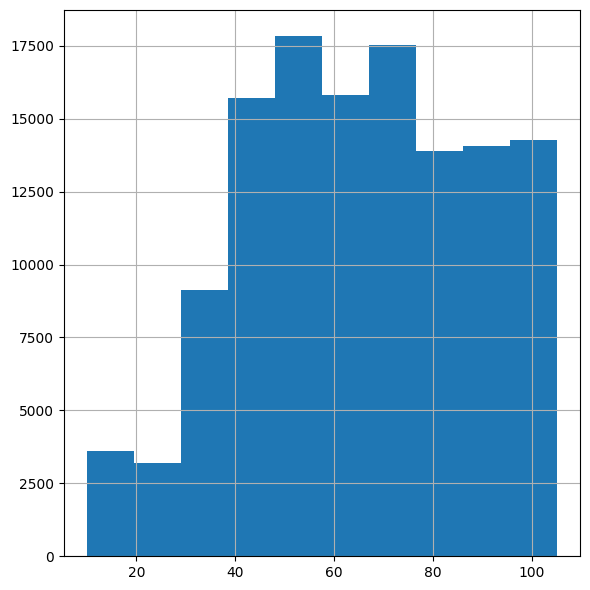

In [292]:
#Plotting the scores of both teams
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

fig, axes = plt.subplots(1, 1)

df["tran_amount"].hist(figsize=(6,6))

plt.show()

In [293]:
# Normality test scores
stat, p = shapiro(df['tran_amount'])
print('Statistics=%.3f, p=%.5f' % (stat, p))

# Defining what we will do depending the result
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    normalizer('tran_amount')
    print('ready')


Statistics=0.978, p=0.00000
ready


c:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [294]:
# Preparing important values to start using the model
transactions = duckdb.query('''SELECT customer_id, MAX(tran_amount) as max_trans, MIN(tran_amount) as min_trans, 
                            MEAN(tran_amount) as trans_mean, count(customer_id) as frequency, min(trans_date) as tran_min_date, 
                            max(trans_date) as tran_max_date
                            FROM df 
                            group by customer_id''').to_df()
transactions.head()

,customer_id,max_trans,min_trans,trans_mean,frequency,tran_min_date,tran_max_date
0,CS1704,0.971429,0.361905,0.642424,22,01-Feb-12,28-Aug-13
1,CS4646,0.980952,0.333333,0.649084,26,04-Dec-12,31-Aug-13
2,CS1861,1.000000,0.333333,0.655238,20,02-Jun-13,30-May-14
3,CS3963,0.980952,0.361905,0.674534,23,02-Jun-13,31-Aug-13
4,CS1431,0.914286,0.333333,0.665079,18,03-May-12,30-Nov-11


## Model usage

In [301]:
X_train_full, X_test = train_test_split(transactions, test_size=0.3, random_state=20)
X_train, X_valid = X_train_full[:-1000], X_train_full[-1000:]

X_train['max_trans'] = X_train['max_trans'].astype(np.float32)
X_train['min_trans'] = X_train['min_trans'].astype(np.float32)
X_train['trans_mean'] = X_train['trans_mean'].astype(np.float32)
X_train['frequency'] = X_train['frequency'].astype(np.int32)

X_train_full['max_trans'] = X_train_full['max_trans'].astype(np.float32)
X_train_full['min_trans'] = X_train_full['min_trans'].astype(np.float32)
X_train_full['trans_mean'] = X_train_full['trans_mean'].astype(np.float32)
X_train_full['frequency'] = X_train_full['frequency'].astype(np.int32)

X_valid['max_trans'] = X_valid['max_trans'].astype(np.float32)
X_valid['min_trans'] = X_valid['min_trans'].astype(np.float32)
X_valid['trans_mean'] = X_valid['trans_mean'].astype(np.float32)
X_valid['frequency'] = X_valid['frequency'].astype(np.int32)

C:\Users\danie\AppData\Local\Temp\ipykernel_14368\4071589324.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['max_trans'] = X_train['max_trans'].astype(np.float32)
C:\Users\danie\AppData\Local\Temp\ipykernel_14368\4071589324.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['min_trans'] = X_train['min_trans'].astype(np.float32)
C:\Users\danie\AppData\Local\Temp\ipykernel_14368\4071589324.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

In [302]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train_full, X_train_full, epochs=5,
                      validation_data=[X_valid, X_valid])

conv_encoder.summary()
conv_decoder.summary()

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).